# Imports

In [17]:
from pathlib import Path
from itertools import chain, product
from flkmeans.utils import distribute_to_clients
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Constants

In [18]:
FOLDER_PATH = Path("experiments")

# Definitions

In [19]:
N_CLIENTS = 100
N_CLIENTS_PER_ROUND = range(5, 101, 5)

In [20]:
# EXPERIMENT = "SYNTHETIC"
# EXPERIMENT = "MNIST"
EXPERIMENT = "FEMNIST"

### Evaluate

In [21]:
N_TOP = 50  # How many values are considered out of 100
ALPHA = 0.2  # The alpha value for the std in the plots
BASED_ON_SCORE = True  # If true, take the 50 values for each metric based on the best scores. If false, take the best 50 values for each metric independently.
SHARE_Y_AXIS = False  # If the scaling of the y-axis in the plots should be the same.
METRICS = ["Loss", "Accuracy", "V-Measure"]  # The metrics which should be plotted
ALGORITHMS = ['k-means', 'EWF k-means', 'DWF k-means', 'k-FED', 'FKM']  # The algorithms which should be plotted

In [22]:
df_raw = pd.read_csv(FOLDER_PATH / EXPERIMENT / f"Results.csv")
df_raw

,Unnamed: 0,Model,Data distribution,Iteration,Clients per Round,Loss,Accuracy,V-Measure,Homogeneity,Completeness
0,0,k-means,IID,0,5,8.302839,0.570413,0.455807,0.506045,0.414644
1,1,k-means,IID,0,10,8.302839,0.570413,0.455807,0.506045,0.414644
2,2,k-means,IID,0,15,8.302839,0.570413,0.455807,0.506045,0.414644
3,3,k-means,IID,0,20,8.302839,0.570413,0.455807,0.506045,0.414644
4,4,k-means,IID,0,25,8.302839,0.570413,0.455807,0.506045,0.414644
...,...,...,...,...,...,...,...,...,...,...
29995,29995,FKM,non-IID,99,80,7.828061,0.480287,0.459186,0.482590,0.437946
29996,29996,FKM,non-IID,99,85,7.830005,0.492426,0.462493,0.487105,0.440257
29997,29997,FKM,non-IID,99,90,7.833957,0.483435,0.457272,0.480787,0.435951
29998,29998,FKM,non-IID,99,95,7.830381,0.485744,0.461447,0.484782,0.440250


In [23]:
def get_mean_and_std(df: pd.DataFrame, model: str, distribution: str) -> tuple[
    pd.DataFrame, pd.DataFrame]:
    df_mean = pd.DataFrame()
    df_std = pd.DataFrame()
    for n in N_CLIENTS_PER_ROUND:
        # Filter relevant data
        filtered_df = df[
            (df["Model"] == model) & (df["Data distribution"] == distribution) & (df["Clients per Round"] == n)]
        # Compute mean
        mean_n_series = filtered_df.loc[
            filtered_df["Loss"].nsmallest(n=N_TOP).index, ["Loss", "Accuracy", "V-Measure", "Homogeneity",
                                                           "Completeness"]].mean()
        df_mean[n] = mean_n_series
        # Compute mean
        std_n_series = filtered_df.loc[
            filtered_df["Loss"].nsmallest(n=N_TOP).index, ["Loss", "Accuracy", "V-Measure", "Homogeneity",
                                                           "Completeness"]].std()
        df_std[n] = std_n_series
    return df_mean, df_std

In [24]:
def replace_name(name: str) -> str:
    d = {"Loss": "Score"}
    if name not in d:
        return name
    else:
        return d[name]

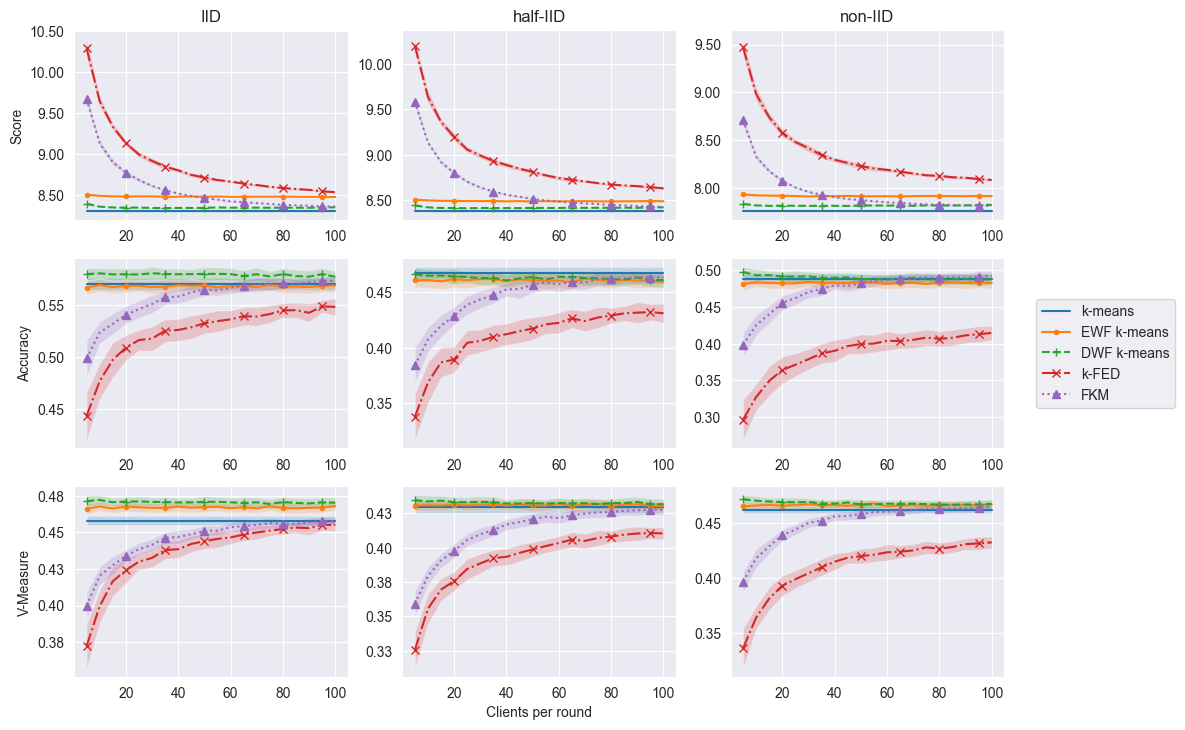

In [25]:
scaling_factor = 0.8
formater = {"IID": '%.2f', "half-IID": '%.2f', "non-IID": '%.2f'}
line_style = {0: "solid", 1: "-", 2: "--", 3: "-.", 4: ":"}
markers = {0: "", 1: ".", 2: "+", 3: "x", 4: "^"}
# All metrics
fig, ax = plt.subplots(len(METRICS), 3, sharey='row' if SHARE_Y_AXIS else False,
                       figsize=(15 * scaling_factor, scaling_factor * 3.5 * len(METRICS)))
for distr_idx, distribution in enumerate(["IID", "half-IID", "non-IID"]):
    for alg_idx, alg in enumerate(ALGORITHMS):
        df_mean, df_std = get_mean_and_std(df_raw, alg, distribution)
        for metric_idx, metric_name in enumerate(METRICS):
            x = df_mean.loc[metric_name, :].index
            y = np.array(df_mean.loc[metric_name, :])
            e = np.array(df_std.loc[metric_name, :])
            ax[metric_idx][distr_idx].plot(x, y, label=replace_name(alg), linestyle=line_style[alg_idx],
                                           marker=markers[alg_idx], markevery=3)
            ax[metric_idx][distr_idx].fill_between(x, y - e, y + e, alpha=ALPHA)
            ax[metric_idx][distr_idx].yaxis.set_major_formatter(FormatStrFormatter(formater[distribution]))
            ax[metric_idx][distr_idx].grid(True)
            ax[metric_idx][0].set_ylabel(replace_name(metric_name))
ax[0][0].set_title("IID")
ax[0][1].set_title("half-IID")
ax[len(METRICS) - 1][1].set_xlabel("Clients per round")
ax[0][2].set_title("non-IID")
lgd = ax[1][2].legend(loc='center right', fancybox=True, shadow=False, bbox_to_anchor=(1.65, 0.5), frameon=True)
fig.savefig(FOLDER_PATH / EXPERIMENT / f"All_metrics_for_{N_CLIENTS}_clients_total.pdf", dpi=300, format="pdf",
            bbox_extra_artists=(lgd,), bbox_inches='tight')

# Code to generate latex result tables

In [26]:
df_raw

,Unnamed: 0,Model,Data distribution,Iteration,Clients per Round,Loss,Accuracy,V-Measure,Homogeneity,Completeness
0,0,k-means,IID,0,5,8.302839,0.570413,0.455807,0.506045,0.414644
1,1,k-means,IID,0,10,8.302839,0.570413,0.455807,0.506045,0.414644
2,2,k-means,IID,0,15,8.302839,0.570413,0.455807,0.506045,0.414644
3,3,k-means,IID,0,20,8.302839,0.570413,0.455807,0.506045,0.414644
4,4,k-means,IID,0,25,8.302839,0.570413,0.455807,0.506045,0.414644
...,...,...,...,...,...,...,...,...,...,...
29995,29995,FKM,non-IID,99,80,7.828061,0.480287,0.459186,0.482590,0.437946
29996,29996,FKM,non-IID,99,85,7.830005,0.492426,0.462493,0.487105,0.440257
29997,29997,FKM,non-IID,99,90,7.833957,0.483435,0.457272,0.480787,0.435951
29998,29998,FKM,non-IID,99,95,7.830381,0.485744,0.461447,0.484782,0.440250


In [27]:
index_upper = list(product(["Score"], ["IID", "half-IID", "non-IID"], ["mean", "min", "std"]))
index_lower = list(product(["Accuracy", "V-Measure"], ["IID", "half-IID", "non-IID"], ["mean", "max", "std"]))
index = index_upper + index_lower

In [28]:
multiindex = pd.MultiIndex.from_tuples(index, names=("Metric", "Data distribution", "Value"))

In [29]:
multiindex

MultiIndex([(    'Score',      'IID', 'mean'),
            (    'Score',      'IID',  'min'),
            (    'Score',      'IID',  'std'),
            (    'Score', 'half-IID', 'mean'),
            (    'Score', 'half-IID',  'min'),
            (    'Score', 'half-IID',  'std'),
            (    'Score',  'non-IID', 'mean'),
            (    'Score',  'non-IID',  'min'),
            (    'Score',  'non-IID',  'std'),
            ( 'Accuracy',      'IID', 'mean'),
            ( 'Accuracy',      'IID',  'max'),
            ( 'Accuracy',      'IID',  'std'),
            ( 'Accuracy', 'half-IID', 'mean'),
            ( 'Accuracy', 'half-IID',  'max'),
            ( 'Accuracy', 'half-IID',  'std'),
            ( 'Accuracy',  'non-IID', 'mean'),
            ( 'Accuracy',  'non-IID',  'max'),
            ( 'Accuracy',  'non-IID',  'std'),
            ('V-Measure',      'IID', 'mean'),
            ('V-Measure',      'IID',  'max'),
            ('V-Measure',      'IID',  'std'),
            (

In [30]:
df = pd.DataFrame(index=multiindex, columns=ALGORITHMS)
df

k-means EWF k-means DWF k-means k-FED  FKM
Metric    Data distribution Value                                           
Score     IID               mean      NaN         NaN         NaN   NaN  NaN
                            min       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          half-IID          mean      NaN         NaN         NaN   NaN  NaN
                            min       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          non-IID           mean      NaN         NaN         NaN   NaN  NaN
                            min       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
Accuracy  IID               mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          half-IID          mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          non-IID           mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
V-Measure IID               mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          half-IID          mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN
          non-IID           mean      NaN         NaN         NaN   NaN  NaN
                            max       NaN         NaN         NaN   NaN  NaN
                            std       NaN         NaN         NaN   NaN  NaN

In [31]:
for metric, dist, value in multiindex:
    for model in ALGORITHMS:
        filtered_df = df_raw[
            (df_raw["Model"] == model) & (df_raw["Data distribution"] == dist) & (df_raw["Clients per Round"] == 100)]
        # Compute mean
        pd_filter = filtered_df["Loss"].nsmallest(n=N_TOP).index
        if value == "mean":
            v = filtered_df.loc[pd_filter, metric if metric != "Score" else "Loss"].mean()
        elif value == "std":
            v = filtered_df.loc[pd_filter, metric if metric != "Score" else "Loss"].std()
        else:
            if metric == "Score":
                v = filtered_df.loc[pd_filter, "Loss"].min()
            else:
                v = filtered_df.loc[pd_filter, metric].max()
        df.loc[(metric, dist, value), model] = v

C:\Users\holzer\AppData\Local\Temp\ipykernel_34024\3752599049.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(metric, dist, value), model] = v


In [32]:
print(df.to_latex())

\begin{tabular}{llllllll}
\toprule
 &  &  & k-means & EWF k-means & DWF k-means & k-FED & FKM \\
Metric & Data distribution & Value &  &  &  &  &  \\
\midrule
\multirow[t]{9}{*}{Score} & \multirow[t]{3}{*}{IID} & mean & 8.307061 & 8.479640 & 8.352683 & 8.537065 & 8.361624 \\
 &  & min & 8.292601 & 8.460570 & 8.336608 & 8.512410 & 8.349832 \\
 &  & std & 0.005736 & 0.008260 & 0.005884 & 0.012321 & 0.005036 \\
\cline{2-8}
 & \multirow[t]{3}{*}{half-IID} & mean & 8.381572 & 8.488637 & 8.420780 & 8.630366 & 8.424279 \\
 &  & min & 8.362896 & 8.471265 & 8.397086 & 8.584459 & 8.398106 \\
 &  & std & 0.006973 & 0.007565 & 0.007212 & 0.013529 & 0.007366 \\
\cline{2-8}
 & \multirow[t]{3}{*}{non-IID} & mean & 7.761290 & 7.917945 & 7.825941 & 8.087121 & 7.814480 \\
 &  & min & 7.751317 & 7.897086 & 7.806932 & 8.059554 & 7.800988 \\
 &  & std & 0.004381 & 0.009943 & 0.008427 & 0.011812 & 0.006393 \\
\cline{1-8} \cline{2-8}
\multirow[t]{9}{*}{Accuracy} & \multirow[t]{3}{*}{IID} & mean & 0.569952 & 